In [29]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
from timm.models.layers.conv2d_same import Conv2dSame
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns

import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from monai.transforms import Resize
import monai.transforms as transforms

import SegmentationModel
import CreateMonaiDataSet

import warnings
warnings.filterwarnings("ignore")

**Define required directories**

In [2]:

data_dir = 'D:\RSNA-2022-cervical-spine-fracture-detection'
log_dir = './logs'
model_dir = './models'

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

**Define Transformations for input images to monai's inputs**

In [3]:
img_size = [128,128,128]
# Resize the input image to spatial size
monai_img_size = Resize(img_size)
#translate_range, a sequence of positive floats, is used to generate the n shift parameters
translate_range = [int(x*y) for x,y in zip(img_size, (0.3, 0.3, 0.3))]


transform_train_data = transforms.Compose([
    transforms.RandFlipd(keys=["image","mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(["image","mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image","mask"], translate_range=translate_range, padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest")
])

transform_valid_data = transforms.Compose()

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


**Load DataFrames**

*Train csv file*

In [9]:
df_train = pd.read_csv(os.path.join(data_dir,'train.csv'))
num_patients = df_train["StudyInstanceUID"].unique().size
df_train.head(10)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1


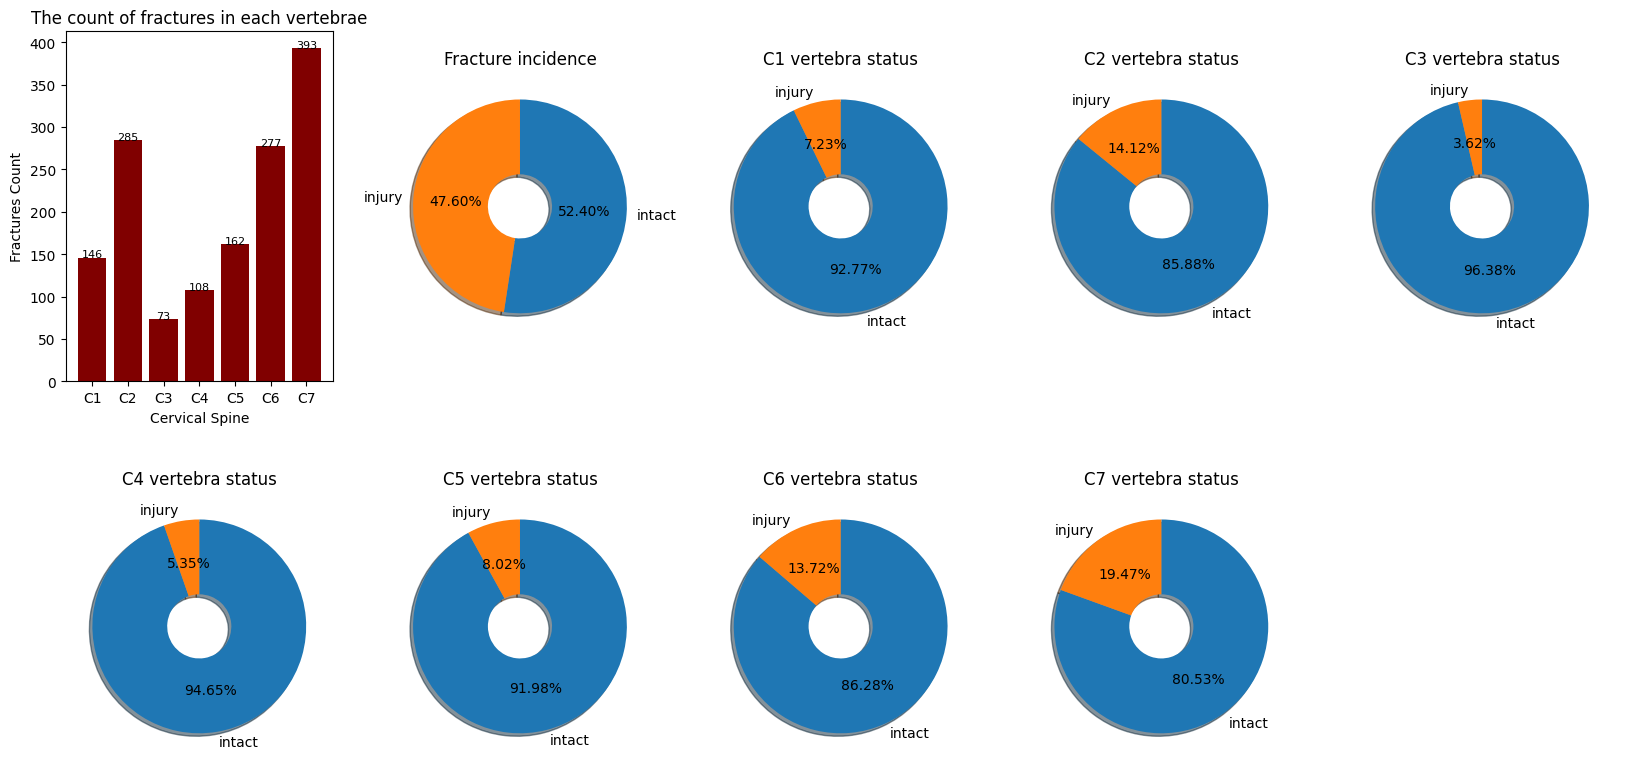

In [109]:
fig = plt.figure(figsize = (20,10))
rows = 2
cols = 5
item = 1

count_fractures = {}
for i in range(7):
    count_fractures[f"C{i+1}"] = df_train.query(f"C{i+1}==1").shape[0]

ax = fig.add_subplot(rows, cols, item)
ax.bar(count_fractures.keys(), count_fractures.values(), color='maroon')
plt.xlabel("Cervical Spine")
plt.ylabel("Fractures Count")
plt.title("The count of fractures in each vertebrae")
for i in range(len(count_fractures)):
    plt.annotate(str(count_fractures[f"C{i+1}"]), xy=(i,count_fractures[f"C{i+1}"]), horizontalalignment="center", fontsize=8)


def plot_pie_chart(data,title):
    global item, fig, rows, cols
    item += 1
    ax = fig.add_subplot(rows, cols, item)
    status = {0:"intact", 1:"injury"}
    ax.pie(data, labels=[status[x] for x in data.index], autopct='%.2f%%', startangle=90, counterclock=False, wedgeprops={'width': 0.7}, shadow = True)
    ax.set_title(title)

patient_overall = df_train["patient_overall"].value_counts()
plot_pie_chart(patient_overall, "Fracture incidence")

c1 = df_train["C1"].value_counts()
plot_pie_chart(c1, "C1 vertebra status")

c2 = df_train["C2"].value_counts()
plot_pie_chart(c2, "C2 vertebra status")

c3 = df_train["C3"].value_counts()
plot_pie_chart(c3, "C3 vertebra status")

c4 = df_train["C4"].value_counts()
plot_pie_chart(c4, "C4 vertebra status")

c5 = df_train["C5"].value_counts()
plot_pie_chart(c5, "C5 vertebra status")

c6 = df_train["C6"].value_counts()
plot_pie_chart(c6, "C6 vertebra status")

c7 = df_train["C7"].value_counts()
plot_pie_chart(c7, "C7 vertebra status")

plt.savefig("assets/train_csv_visualization.png")

In [21]:
mask_files = os.listdir(f"{data_dir}/segmentations")
print(f"Number of mask files: {len(mask_files)}")

df_mask = pd.DataFrame({"mask_path":mask_files})
df_mask["StudyInstanceUID"] = df_mask["mask_path"].apply(lambda x:x[:-4])
df_mask["mask_path"] = df_mask["mask_path"].apply(lambda x: os.path.join(data_dir,'segmentations',x))
df_mask.head()

Number of mask files: 87


,mask_path,StudyInstanceUID
0,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.10633
1,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.10921
2,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.11827
3,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.11988
4,D:\RSNA-2022-cervical-spine-fracture-detection...,1.2.826.0.1.3680043.12281


In [22]:
df = df_train.merge(df_mask, on='StudyInstanceUID', how='left')
df['image_folder'] = df['StudyInstanceUID'].apply(lambda x: os.path.join(data_dir,'train_images',x))
df['mask_path'].fillna('',inplace=True)
print(df.shape)
df.head()

(2019, 11)


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_path,image_folder
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,,D:\RSNA-2022-cervical-spine-fracture-detection...
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,,D:\RSNA-2022-cervical-spine-fracture-detection...
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,,D:\RSNA-2022-cervical-spine-fracture-detection...
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,,D:\RSNA-2022-cervical-spine-fracture-detection...
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...


In [23]:
df_segments = df.query('mask_path != ""').reset_index(drop=True)
print(df_segments.shape)
df_segments.head()

(87, 11)


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_path,image_folder
0,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...
1,1.2.826.0.1.3680043.25704,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...
2,1.2.826.0.1.3680043.20647,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...
3,1.2.826.0.1.3680043.31077,1,0,0,1,1,1,1,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...
4,1.2.826.0.1.3680043.17960,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...


**K-Fold Cross Validation**

In [24]:
# Split data into train and validation set with KFOLD Cross validation
k = 5
kf = KFold(n_splits=k, random_state=None)

df_segments['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_segments)):
    df_segments.loc[valid_idx,'fold'] = fold

df_segments.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_path,image_folder,fold
0,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0
1,1.2.826.0.1.3680043.25704,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0
2,1.2.826.0.1.3680043.20647,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0
3,1.2.826.0.1.3680043.31077,1,0,0,1,1,1,1,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0
4,1.2.826.0.1.3680043.17960,0,0,0,0,0,0,0,0,D:\RSNA-2022-cervical-spine-fracture-detection...,D:\RSNA-2022-cervical-spine-fracture-detection...,0


**Convert 2D input to 3D** 

DICOM images are in axial format, while NIFTI files are in Sagittal plane. So, We should convert the segmentation model to 3D model.

In [25]:
'''
    3D transformers  to change 2d inputs (DICOM Images)to 3d outputs (NIFTI Images)
'''
def Convert_2DT3D(module):
    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
    elif isinstance(module, Conv2dSame):
        print("conv2Dsame")
    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride= module.stride[0],
            padding= module.padding[0],
            dilation=module.dilation[0],
            bias = module.bias is not None,
            padding_mode= module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size= module.kernel_size,
            stride= module.stride,
            padding= module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size= module.kernel_size,
            stride=module.stride,
            padding= module.padding,
            ceil_mode= module.ceil_mode
        )
    for name, child in module.named_children():
        module_output.add_module(name, Convert_2DT3D(child))
    return module_output

In [29]:
for fold in range(5):
    ds_train = df_segments[df_segments['fold'] != fold].reset_index(drop=True)
    ds_valid_ = df_segments[df_segments['fold'] == fold].reset_index(drop=True)
    ds_train.to_csv("train.csv")
    dataset_train = CreateMonaiDataSet.CreateMonaiDataset(ds_train,'train',transform_train_data)
    print(dataset_train[0].shape)
    # dataset_valid = CreateMonaiDataset(ds_valid_, 'valid', transform=transform_valid_data)    
    # loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)    
    # loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=4, shuffle=False, num_workers=4)
    # model = SegmentationModel.SegModel('resnet18')
    # model = Convert_2DT3D(model)
    # model = model.to(device)

(3, 128, 128, 164)
(3, 128, 128, 199)
(3, 128, 128, 199)
(3, 128, 128, 199)
(3, 128, 128, 199)
